In [4]:
import geopandas as gp
import pandas as pd
import random
import math
import copy
from shapely import union, STRtree
from shapely.geometry import Point, Polygon
from PIL import ImageFont

# Demo only
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm

def generate_town_name() -> str:
	a = ["Test", "Trial", "Foo", "Bar", "Placeholder"]
	b = ["Town", "City", "Village", "Township", "Creek", ""]
	return f"{random.choice(a)} {random.choice(b)}"

def generate_random_points(point_count: int = 20) -> gp.GeoDataFrame:
	points = [Point(random.randrange(0,50),random.randrange(0,50)) for i in range(point_count)]
	gdf = gp.GeoDataFrame(
		data={"name": [generate_town_name() for i in range(point_count)], "geometry": points},
		geometry="geometry",
		crs='EPSG:4326'
	)
	return gdf

cities = generate_random_points(30)


<Axes: >

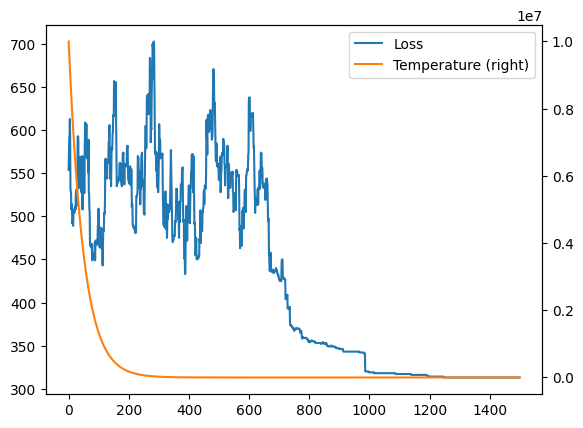

In [5]:
debug_energy = []
debug_temperature = []

# https://www.e-education.psu.edu/geog486/node/557
label_positions = [
	["top-right", 0],
	["top-left", 1],
	["bottom-right", 1],
	["bottom-left", 2],
	["top-center", 3],
	["bottom-center", 4],
]

label_margin = .5;

def rect_to_points(bounds):
	x1,y1,x2,y2 = bounds
	return (
		(x1,y1),
		(x2,y1),
		(x2,y2),
		(x1,y2),
		(x1,y1),
	)

def get_label_coords(point, label_text: str, label_pos: int):
	# Given a point, text, and label_position, return [x1,y1,x2,y2]
	x1,y1,x2,y2 = (0,)*4
	label_position = label_positions[label_pos][0]
	
	atlas = ImageFont.FreeTypeFont("../fonts/Atlas Grotesk Regular.ttf", size=1.25)

	bbox = atlas.getbbox(label_text)
	width = atlas.getlength(label_text)
	height = (bbox[3] - bbox[1]) * .9

	if ("left" in label_position):
		x1 = point[0] - label_margin
		x2 = x1 - width		
	if ("right" in label_position):
		x1 = point[0] + label_margin
		x2 = x1 + width
	if ("center" in label_position):
		x1 = point[0] - width / 2
		x2 = x1 + width
	if ("top" in label_position):
		y1 = point[1] + label_margin
		y2 = y1 + height
	if ("bottom" in label_position):
		y1 = point[1] - label_margin
		y2 = y1 - height

	return (x1,y1,x2,y2) 

time_limit = 2500;

def get_temperature(t):
	# Given t, return the current temperatue in the annealing schedule (exponential decay)
	return (.98 ** t) * 1e7

def get_neighbour(state):
	# Generate a random neighbour of a given state by moving a single label
	i = random.randrange(0, len(state))
	label_choices = [pos for pos in list(range(len(label_positions))) if pos != state[i]["label_pos"]]
	state[i]["label_pos"] = random.choice(label_choices)
	state[i]["label_coords"] = get_label_coords(
		state[i]["feature_coords"],
		state[i]["label_text"],
		state[i]["label_pos"])
	return state

def get_energy(state):
	# Compute the energy of a given state
	e = 0;
	geoms = [Polygon(rect_to_points(point["label_coords"])).buffer(1) for point in state]
	tree = STRtree(geoms)

	for i, point in enumerate(state):
		geom = Polygon(rect_to_points(point["label_coords"]))
		lp = label_positions[point["label_pos"]]
		# Label positions cost
		e += lp[1]
		# Overlap cost
		e += len(tree.query(geom, predicate="intersects")) * 10
	return e

def get_acceptance_prob(e, e_new, temperature):
	if (e_new < e):
		return 1
	else:
		return math.e ** (-1 * (e_new - e) / temperature)

def place_labels(gdf: gp.GeoDataFrame) -> gp.GeoDataFrame:
	
	# Generate random initial state
	state = []
	for i, obj in gdf.iterrows():
		label_text = obj["name"]
		label_pos = random.randrange(len(label_positions))
		feature_coords = (obj.geometry.x, obj.geometry.y)

		state.append({
		"feature_coords": feature_coords,
		"label_text": label_text,
		"label_pos": label_pos,
		"label_pos_name": label_positions[label_pos][0],
		"label_coords": get_label_coords(
			feature_coords,
			label_text,
			label_pos,
		)})

	t = 0
	while t < time_limit:
		temperature = get_temperature(t)
		state_new = get_neighbour(copy.deepcopy(state))
		e = get_energy(state)
		e_new = get_energy(state_new)
		if (get_acceptance_prob(e, e_new, temperature) > random.uniform(0,1)):
			state = copy.deepcopy(state_new)
		debug_energy.append(e)
		debug_temperature.append(temperature)
		t += 1;
	return state


labels = place_labels(cities)

label_boxes = gp.GeoDataFrame(
	data={
		"label_text": [l["label_text"] for l in labels],
		"geometry": [Polygon(rect_to_points(l["label_coords"])) for l in labels]},
	geometry="geometry",
	crs='EPSG:4326'
)

axd = pd.DataFrame(debug_energy, columns=["Loss"]).plot()
pd.DataFrame(debug_temperature, columns=["Temperature"]).plot(ax=axd, secondary_y=True)

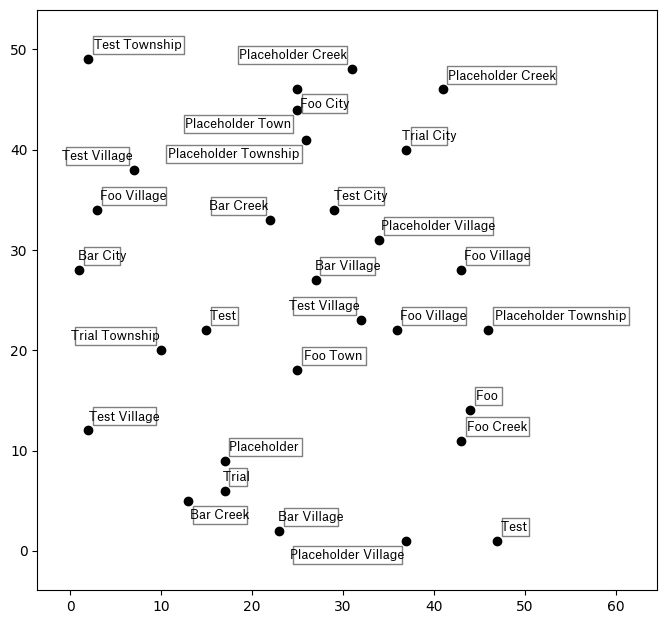

In [6]:
atlas_regular = fm.FontProperties(fname='../fonts/Atlas Grotesk Regular.ttf')

fig, ax = plt.subplots(figsize=(8, 8))
cities.plot(ax=ax, color="black")
label_boxes.plot(ax=ax, color="none", edgecolor="gray")

for i, l in label_boxes.iterrows():
    plt.text(l.geometry.centroid.x, l.geometry.centroid.y, l.label_text, fontproperties=atlas_regular, fontsize=9, horizontalalignment="center", verticalalignment="center")